# **Predicting Wine Quality Through Classification and Regression**
#### DSCI 100 Winter T2 Group 006-042

## Introduction:

Consumer selection on wine has been heavily dependent on quality certifications for purchasing decisions and producers have been doing the same for pricing (Cortez et al., 2009). The certification for wine quality is a tedious process, requiring wine experts (connoisseurs) to sample the taste and smell of the wine to determine its quality (Cortez et al., 2009). However, there are biases when conducting these sensory taste tests due to personal preferences of the experts and the complex nature of the human taste bud (Smith and Margolskee, 2001).

This poses the question as to whether regression and classification can be used to build a predictive model for deciding upon an objective evaluation of wine quality. In saying, we would like to determine what properties have the most influence in wine quality.

Cortez et al. (2009) obtained physicochemical data of 1599 vinho verde red wine samples from Portugal during the certification phase of wine production from May 2004 to February 2007. They collected sensory data based on the average grading by three human assessors on a scale of 0 - 10. The physicochemical data describes many factors of wine that may affect taste preference and quality.

## Preliminary Exploratory Data Analysis:

In [4]:
# loading libraries
library(tidyverse)
library(tidymodels)
library(gridExtra)

#### Attribute (units):
- Fixed acidity ($g/dm^3$)
- Volatile acidity ($g/dm^3$)
- Citric acid ($g/dm^3$)
- Residual sugar ($g/dm^3$)
- Chlorides ($g/dm^3$)
- Free sulfur dioxide ($mg/dm^3$)
- Total sulfur dioxide ($mg/dm^3$)
- Density ($g/cm^3$)
- pH
- Sulphates ($g/dm^3$)
- Alcohol ($vol.\%$)

In [5]:
# reading data
data <- read_csv("data/red_wine_quality.csv")

Parsed with column specification:
cols(
  `fixed acidity` = col_double(),
  `volatile acidity` = col_double(),
  `citric acid` = col_double(),
  `residual sugar` = col_double(),
  chlorides = col_double(),
  `free sulfur dioxide` = col_double(),
  `total sulfur dioxide` = col_double(),
  density = col_double(),
  pH = col_double(),
  sulphates = col_double(),
  alcohol = col_double(),
  quality = col_double()
)



In [6]:
# cleaning and wrangling data
colnames(data) <- gsub(" ", "_", names(data))
colnames(data)[colnames(data) %in% c("free_sulfur_dioxide", "total_sulfur_dioxide")] <- c("free_so2", "total_so2")

clean_data <- data %>%
              mutate(quality = as_factor(quality))
# %>%
#               subset(select = -c(fixed_acidity, volatile_acidity, citric_acid, free_so2))

In [7]:
# splitting data
set.seed(100)
clean_data_split <- initial_split(clean_data, prop = 0.5, strata = quality)
train_data <- training(clean_data_split)
test_data <- testing(clean_data_split)

In [8]:
glimpse(train_data)

Rows: 800
Columns: 12
$ fixed_acidity    <dbl> 7.8, 11.2, 7.4, 7.9, 7.5, 6.7, 5.6, 8.5, 7.4, 7.9, 7…
$ volatile_acidity <dbl> 0.760, 0.280, 0.660, 0.600, 0.500, 0.580, 0.615, 0.2…
$ citric_acid      <dbl> 0.04, 0.56, 0.00, 0.06, 0.36, 0.08, 0.00, 0.56, 0.08…
$ residual_sugar   <dbl> 2.3, 1.9, 1.8, 1.6, 6.1, 1.8, 1.6, 1.8, 4.4, 1.8, 1.…
$ chlorides        <dbl> 0.092, 0.075, 0.075, 0.069, 0.071, 0.097, 0.089, 0.0…
$ free_so2         <dbl> 15, 17, 13, 15, 17, 15, 16, 35, 6, 17, 10, 9, 21, 10…
$ total_so2        <dbl> 54, 60, 40, 59, 102, 65, 59, 103, 29, 56, 37, 67, 40…
$ density          <dbl> 0.9970, 0.9980, 0.9978, 0.9964, 0.9978, 0.9959, 0.99…
$ pH               <dbl> 3.26, 3.16, 3.51, 3.30, 3.35, 3.28, 3.58, 3.30, 3.38…
$ sulphates        <dbl> 0.65, 0.58, 0.56, 0.46, 0.80, 0.54, 0.52, 0.75, 0.50…
$ alcohol          <dbl> 9.8, 9.8, 9.4, 9.4, 10.5, 9.2, 9.9, 10.5, 9.0, 9.2, …
$ quality          <fct> 5, 6, 5, 5, 5, 5, 5, 7, 4, 6, 5, 5, 6, 5, 5, 6, 6, 5…


In [9]:
# summarizing data
train_data_mean_summary <- train_data %>%
                           mutate(quality = as.numeric(quality)) %>%
                           map_dfr(mean, na.rm = TRUE)

colnames(train_data_mean_summary) <- paste("mean", colnames(train_data_mean_summary), sep = "_")

train_data_quality_summary <- train_data %>%
                              group_by(quality) %>%
                              summarize(count = n(),
                                        proportion = n() / nrow(train_data) * 100)

`summarise()` ungrouping output (override with `.groups` argument)



In [10]:
# mean of predictor variables and classifier
train_data_mean_summary

mean_fixed_acidity,mean_volatile_acidity,mean_citric_acid,mean_residual_sugar,mean_chlorides,mean_free_so2,mean_total_so2,mean_density,mean_pH,mean_sulphates,mean_alcohol,mean_quality
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.27125,0.5275813,0.2728,2.544188,0.08852375,16.12875,46.7925,0.9967183,3.311362,0.6569,10.41125,3.63


In [11]:
# count of classifier
train_data_quality_summary

quality,count,proportion
<fct>,<int>,<dbl>
3,6,0.750
4,25,3.125
5,342,42.750
6,320,40.000
7,100,12.500
8,7,0.875


In [16]:
# scaling data
train_data_scaled <- train_data %>%
                     mutate_at(vars(-quality),
                               ~(scale(., center = TRUE) %>% as.vector))

In [13]:
# visualizing data
alcohol_plot <- train_data %>%
                ggplot(aes(x = quality, y = alcohol)) +
                geom_boxplot() +
                theme(text = element_text(size = 14))
sulphates_plot <- train_data %>%
                  ggplot(aes(x = quality, y = sulphates)) +
                  geom_boxplot() +
                  theme(text = element_text(size = 14))
total_so2_plot <- train_data %>%
                  ggplot(aes(x = quality, y = total_so2)) +
                  geom_boxplot() +
                  theme(text = element_text(size = 14))
residual_sugar_plot <- train_data %>%
                       ggplot(aes(x = quality, y = residual_sugar)) +
                       geom_boxplot() +
                       theme(text = element_text(size = 14))
fixed_acidity_plot <- train_data %>%
                      ggplot(aes(x = quality, y = fixed_acidity)) +
                      geom_boxplot() +
                      theme(text = element_text(size = 14))

quality_summary_plot <- train_data_quality_summary %>%
                                   ggplot(aes(x = quality, y = count)) +
                                   geom_bar(stat = "identity") +
                                   labs(x = "Quality", y = "Count") +
                                   theme(text = element_text(size = 14))

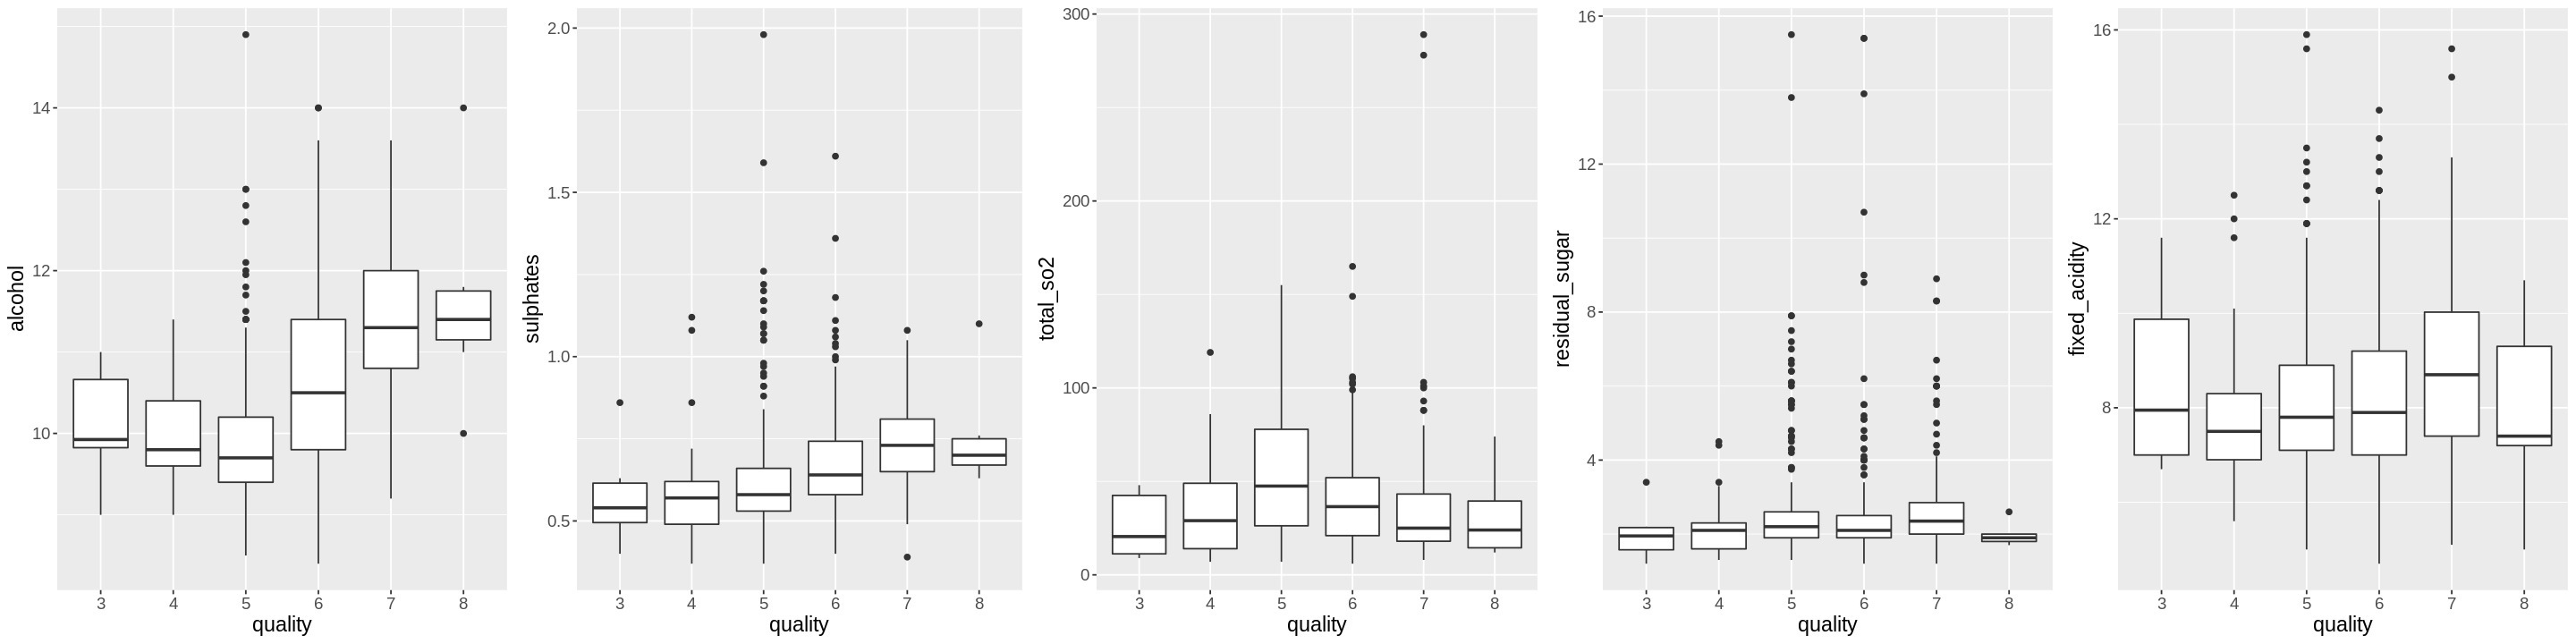

In [14]:
# predictor variables boxplots
options(repr.plot.width = 24, repr.plot.height = 6)
summary_plot <- grid.arrange(alcohol_plot, sulphates_plot, total_so2_plot, residual_sugar_plot, fixed_acidity_plot, nrow=1)

In [15]:
# count of classifier plot
options(repr.plot.width = 10, options.repr.plot.height = 15)
train_data_quality_summary_plot

ERROR: Error in eval(expr, envir, enclos): object 'train_data_quality_summary_plot' not found


## Methods:

Our data analysis will be conducted using a regression model (k-nearest-neighbours) and classification via supervised learning. We will be using alcohol, sulphates, total sulfur dioxide, residual sugar and fixed acidity as our predictors to help predict and classify the wine quality. When analyzing the outcomes, our results will be visualized on a bar plot.
 


## Expected Outcomes and Significance:

We expect to see that our chosen predictors will greatly influence the quality of wine depending on their relative proportions. That is, we expect that all of our predictors have individual influence over the wine quality, and when combined in a model, each predictor acts to amplify the accuracy of the quality predictions.

The impact of these findings may help improve the wine industry. In recent years, this industry is growing and thus there is an increased interest in investing in more innovative techniques that may enhance wine production as well as its selling. Our work aims to integrate subjective rankings to objective measures so that people can extrapolate these findings and make better quality wines. These variables are able to be controlled and manipulated during production. Thus, our findings may be used by oenologists to improve their wine production.

Future questions that may arise include those concerned over what other potential factors may influence the quality of wine or whether the interaction between variables has a greater impact than considered singularly. Further assessment may attempt to discover relationships between variables that together produce a stronger prediction of wine quality. This analysis may also raise the question of whether subjective experience or objective measures matter most. It is possible that personal and sensory experiences play a larger role in shaping wine quality rankings. Therefore, further analysis may explore these subjective factors.


## Working Data Analysis:

In [ ]:
# creating a model

set.seed(7)

predictor_train_data <- train_data %>% select(c(quality, fixed_acidity, residual_sugar, alcohol, sulphates, total_so2, fixed_acidity))

recipe <- recipe(quality ~., data = predictor_train_data) %>%
step_scale(all_predictors()) %>%
step_center(all_predictors())

model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
set_engine("kknn") %>%
set_mode("classification")

vfold <- vfold_cv(predictor_train_data, v = 5, strata = quality)

# code below yeilded a very variable k plot of accuracy, best k's = 1, 6, 76, 36, 11, and 56. All a accuracies around 0.56.
# so i limited it to a smaller range.  

# k_vals <- tibble(neighbors = seq(1,100,5))

# train_fit <- workflow() %>%
# add_recipe(recipe) %>%
# add_model(model) %>%
# tune_grid(resamples = vfold, grid = k_vals) %>%
# collect_metrics() %>%
# filter(.metric == "accuracy") %>%
# arrange(mean)

# tail(train_fit)

# k_plot <- ggplot(train_fit, aes(x=neighbors, y=mean)) + geom_point() + geom_line()
# k_plot

# code below yeilded a fairly variable k plot of accuracy, but k = 35 likely best for preventing under and overfitting.
# k = 29 also does not vary as much from nearby points.

# k_vals_2 <- tibble(neighbors = seq(25,80,2))

# train_fit_2 <- workflow() %>%
# add_recipe(recipe) %>%
# add_model(model) %>%
# tune_grid(resamples = vfold, grid = k_vals_2) %>%
# collect_metrics() %>%
# filter(.metric == "accuracy") %>%
# arrange(mean)

# tail(train_fit_2)

# k_plot_2 <- ggplot(train_fit_2, aes(x=neighbors, y=mean)) + geom_point() + geom_line()
# k_plot_2

# using best model of k = 35, with accuracy 0.5587600.

best_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 35) %>%
set_engine("kknn") %>%
set_mode("classification")

train_fit <- workflow() %>%
add_recipe(recipe) %>%
add_model(best_model) %>%
fit(predictor_train_data)

predict_accuracy <- predict(train_fit, test_data) %>%
bind_cols(test_data) %>%
metrics(truth = quality, estimate = .pred_class) %>%
filter(.metric == "accuracy")
predict_accuracy

# above code gives 0.5957447 evaluation accuracy which is better than chance alone.


In [22]:
# creating model using variable support vector machine from paper

set.seed(7)

train_data_SVM <- train_data %>% 
    select(c(quality, fixed_acidity, alcohol, sulphates, total_so2, free_so2, volatile_acidity, pH))

SVM_recipe <- recipe(quality ~., data = train_data_SVM) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors())

SVM_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification") 

SVM_vfold <- vfold_cv(train_data_SVM, v = 5, strata = quality)

k_value <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

#SVM_results <- workflow() %>% 
#    add_recipe(SVM_recipe) %>% 
#    add_model(SVM_model) %>% 
#    tune_grid(resamples = SVM_vfold, grid = k_value) %>% 
#    collect_metrics()

#k_accuracies <- SVM_results %>% 
#    filter(.metric == "accuracy")

#k_accuracies

#accuracy_vs_k <- ggplot(k_accuracies, aes(x = neighbors, y = mean)) +
#    geom_point() +
#    geom_line() +
#    labs(x = "Neighbors", y = "Accuracy Estimate") +
#    theme(text = element_text(size = 12))

#accuracy_vs_k

# from the graph, we select 75 as the k value because it has a relatively high accuracy estimate and is consistent with nearby values

best_SVM_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 75) %>%
    set_engine("kknn") %>%
    set_mode("classification")

SVM_fit <- workflow() %>%
    add_recipe(SVM_recipe) %>%
    add_model(best_SVM_model) %>%
    fit(data = train_data_SVM)

SVM_predictions <- predict(SVM_fit, test_data) %>%
    bind_cols(test_data) %>%
    metrics(truth = quality, estimate = .pred_class) %>%
    filter(.metric == "accuracy")
SVM_predictions

! Fold1: internal: No observations were detected in `truth` for level(s): '3'
Com...

! Fold4: internal: No observations were detected in `truth` for level(s): '3', '8...



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6107635


## References

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., Reis, J. (2009). Modeling wine 
	preferences by data mining from physicochemical properties. Decision 
	Support Systems. 47, 547-553. https://doi.org/10.1016/j.dss.2009.05.016.
 
Smith, D. V., & Margolskee, R. F. (2001). Making Sense of Taste. Scientific 
	American, 284, 32–39. http://www.jstor.org/stable/26059127
